# VAR Model estimation with approximated likelihood ratios

Juan Pavez, April 2017.

In this notebook we study the usability of the method [Approximating Likelihood Ratios with Calibrated Discriminative Classifiers](http://inspirehep.net/record/1377273) for times series parameter estimation.

In this case an Vector Autoregressive (VAR) model is used. The model is defines as
\begin{equation}
y_t = c + A_1 y_{t-1} + u_t,
\end{equation}
where $y_i \in \mathbb{R}^{Kx1}$, $A_1 \in \mathbb{R}^{KxK}$, $c \in \mathbb{R}^{Kx1}$ and $u_t$ is a white noise process in $K$-dimensions with covariance matrix $\Sigma_u$. 
We approximate the coefficients matrix $A_1 = diag(\alpha_0, \alpha_1)$, with $\alpha_0 = 0.5$ and $\alpha_1 = 0.4$ 
for a 2D VAR(1) process.

We approximate the likelihood of the time series using a recurrent neural network $s(x_{1:T})$ as:

\begin{equation}
\frac{p_{X_{1:T}}(x_{1:T}\vert\theta_0)}{p_{X_{1:T}}(x_{1:T}\vert\theta_1)} = \frac{p_U(u=s(x_{1:T})\vert \theta_0)}{p_U(u=s(x_{1:T})\vert\theta_1)}.
\end{equation}


We also show how to produce the data and train the classifiers in parallel using python multiprocessing.

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import theano
import scipy.linalg as L
import pdb
import pickle

import carl

import multiprocessing

plt.set_cmap('viridis')

np.random.seed(1234)

sys.setrecursionlimit(10000)

In [2]:
import statsmodels.tsa.vector_ar.var_model as vector_ar

In [113]:
p_value_ = 1
ndims_ = 2
nparams_ = 2
N_ = 20000
T_ = 50
alpha_value_0 = 0.5
alpha_value_1 = 0.4
sigma_2_value = [[1.,0.],[0.,1.]]
intercept=[0.,0.]
alpha_value_0_bkg = 0.3
alpha_value_1_bkg = 0.3
sigma_2_value_bkg = [[1.,0.],[0.,1.]]

target_position = (alpha_value_0, alpha_value_1)
bkg_position = (alpha_value_0_bkg, alpha_value_1_bkg)
bounds = [(0.3, 0.6), (0.3, 0.6)]
n_points = 5

As = np.linspace(bounds[0][0],bounds[0][1], n_points)
Bs = np.linspace(bounds[1][0],bounds[1][1], n_points)
AA, BB = np.meshgrid(As, Bs)
AABB = np.hstack((AA.reshape(-1, 1),
               BB.reshape(-1, 1)))


In [4]:
class VAR:

    def sample(self, coefs, intercept, sigma_2, n_steps, rng=None):
        return vector_ar.util.varsim(coefs, intercept, sigma_2, steps=n_steps)
    
    def plot(self,steps=1000):
        self.VAR.plotsim(steps)

    def nll(self, X, alphas, intercept, sigma_2):
        """
        Compute the negative log likelihood for a VAR process, 
        using formula from Lutkepohl (2005)
        """
        lags = 1
        trend = 'c'
        alpha_0 = alphas[0]
        alpha_1 = alphas[1]
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        
        VAR = vector_ar.VAR(X)
        VAR.k_trend = k_trend = vector_ar.util.get_trendorder(trend)

        offset = 0
        y = VAR.y[offset:]

        z = vector_ar.util.get_var_endog(y, lags, trend, 
                                         has_constant='skip')
        y_sample = y[lags:]
        intercept = intercept
        params = np.vstack((intercept, coefs.reshape((2,2))))
        #params = np.linalg.lstsq(z, y_sample)[0]
        resid = y_sample - np.dot(z, params)
        omega = np.array(sigma_2)
        
        lastterm = -np.trace(np.dot(np.dot(resid, L.inv(omega)),resid.T))
        
        varfit = vector_ar.VARResults(y, z, params, omega, lags, names=VAR.endog_names,
                    trend=trend, dates=VAR.data.dates, model=self)
        llf = -varfit.llf
        llf += 0.5*lastterm
        return -llf
    
    def rvs(self, n_samples, alpha_0, alpha_1, intercept, sigma_2, random_state=1234):
        rng = np.random.RandomState(random_state) if \
                isinstance(random_state,int) else random_state
        coefs = np.array([alpha_0,0.,0.,alpha_1]
                        ).reshape(p_value_,ndims_,ndims_)
        return self.sample(coefs=coefs,intercept=intercept,
                           sigma_2=sigma_2,
                           n_steps=n_samples,rng=rng)

In [5]:
p0 = VAR()
p1 = VAR()
rng = np.random.RandomState(1234)

n_true = 1000
X_true = np.array([p0.rvs(T_, alpha_value_0, alpha_value_1, intercept,
                          sigma_2_value, random_state=np.random.randint(0,5000))
                   for i in range(n_true)])

In [127]:
from itertools import product
bounds_values = [(np.linspace(bounds[0][0],bounds[0][1], num=5)),
                 (np.linspace(bounds[1][0],bounds[1][1], num=5))]
combinations = list(product(*bounds_values))

In [7]:
def produce_data(value):
    return np.array([p0.rvs(T_, value[0], value[1], intercept, sigma_2_value,
                           random_state=np.random.randint(0,5000))
                   for i in range(N_//2)])   

Producing data from the VAR model in parallel using multiprocessing map function.

In [8]:
Xs = []
ys = []
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)
Xs = pool.map(produce_data, combinations)
pool.close()
X1_ = np.array([p1.rvs(T_, alpha_value_0_bkg, alpha_value_1_bkg, 
                       intercept, sigma_2_value,
                       random_state=np.random.randint(0,5000))
               for i in range(N_//2)])
Xs = np.array(Xs)

In [11]:
X = Xs[0][0]

Plotting a window from the VAR model.

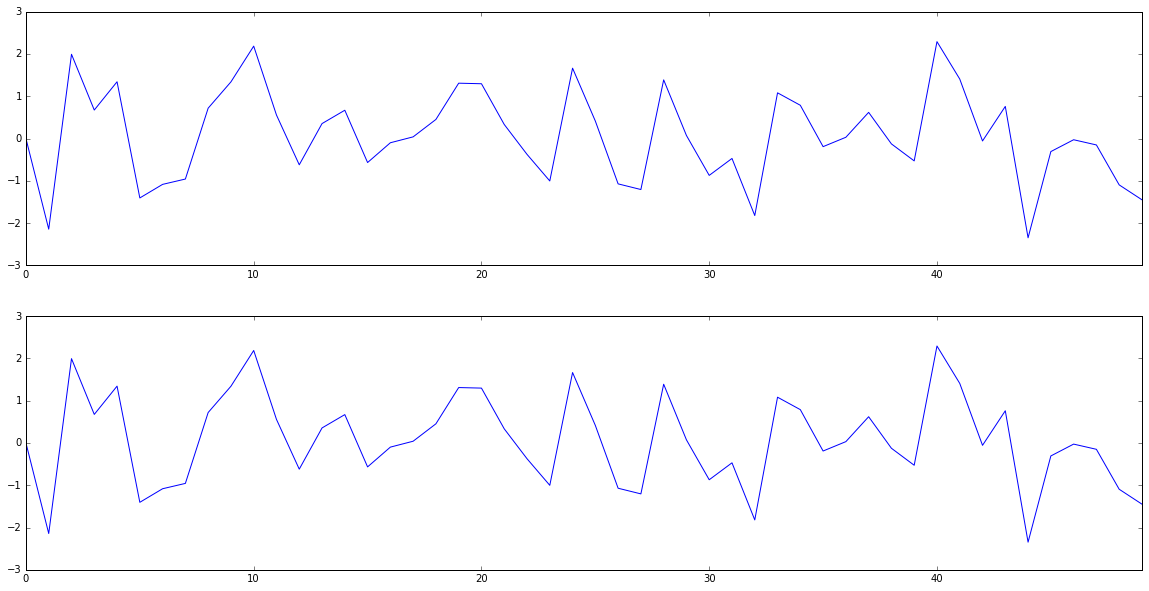

In [9]:
serie1 = X1_[0][:,0]
serie2 = Xs[0][0][:,0]
plt.figure(figsize=(20,10))
plt.subplot(211)
ts = pd.Series(serie1)
ts[0:100].plot()
plt.subplot(212)
ts = pd.Series(serie1)
ts.plot()

In [10]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from carl.learning import as_classifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit


Using Theano backend.


Defining the RNN (in this case GRU) classifier to approximate the likelihood ratio.

In [11]:
def make_model_join():
    model = Sequential()
    model.add(GRU(15, input_shape=(T_, ndims_,)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    sgd = Adam(clipnorm=40.)
    model.compile(loss="binary_crossentropy", optimizer='adam')
    return model

In [14]:
def make_ratio(num):
    X_num = Xs[num]
    X_den = X1_
    X = np.vstack((X_num, X_den))
    y = np.zeros(len(X_num) + len(X_den), dtype=np.int)
    y[len(X_num):] = 1

    clf = KerasClassifier(make_model_join, nb_epoch=50, verbose=0)

    cv =  StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=1)

    ratio = ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20),
        random_state=0)
    ratio.fit(X, y)

    return ratio


Training the classifiers at each grid point in parallel.

In [16]:
print('Start training')
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores)

#clf_ratios = []
n_sample_points = len(combinations)
points = list(range(n_sample_points))
for i, k in enumerate([points[n:n + num_cores] for n in range(0, n_sample_points, num_cores)]):
    if k == 0:
        continue
    print('Iteration {0}'.format(i))
    clf_ratios += pool.map(make_ratio, k)
#pool.close()
print('End training')

Start training
Iteration 0
Iteration 1
Iteration 2
Iteration 3
End training


In [24]:
len(clf_ratios)

25

In [25]:
llr = []
zeros = []
distances = []

for i, theta in enumerate(combinations):
    print(i, theta)
    ratio = clf_ratios[i]
    ratios = ratio.predict(X_true, log=True)
    print ratios[np.isinf(ratios)].shape
    zeros.append(ratios[np.isinf(ratios)].shape[0])
    ratios = ratios[np.logical_and(np.isfinite(ratios),~np.isnan(ratios))]
    nllr = -np.mean(ratios) 
    llr.append(nllr)
    print(llr[-1])

(0, (0.29999999999999999, 0.29999999999999999))
(0,)
-0.00242212620011
(1, (0.29999999999999999, 0.375))
(0,)
-0.165298315616
(2, (0.29999999999999999, 0.44999999999999996))
(0,)
-0.221805591912
(3, (0.29999999999999999, 0.52499999999999991))
(0,)
0.0639796166386
(4, (0.29999999999999999, 0.59999999999999998))
(0,)
0.5854584683
(5, (0.375, 0.29999999999999999))
(0,)
-0.411777495155
(6, (0.375, 0.375))
(0,)
-0.865032252658
(7, (0.375, 0.44999999999999996))
(0,)
-0.796493901549
(8, (0.375, 0.52499999999999991))
(0,)
-0.529063483342
(9, (0.375, 0.59999999999999998))
(0,)
0.0405815752298
(10, (0.44999999999999996, 0.29999999999999999))
(35,)
-0.892447168473
(11, (0.44999999999999996, 0.375))
(0,)
-1.28116686384
(12, (0.44999999999999996, 0.44999999999999996))
(0,)
-1.24965535029
(13, (0.44999999999999996, 0.52499999999999991))
(0,)
-0.860421944937
(14, (0.44999999999999996, 0.59999999999999998))
(0,)
-0.236095468392
(15, (0.52499999999999991, 0.29999999999999999))
(0,)
-1.06390220653
(16, 

In [26]:
llr = np.array(llr)
llr[np.isnan(llr)] = 0.

Computing exact likelihood at same points in order to compare results.

In [27]:
# Computing exact likelihood
exact_contours = np.zeros(len(AABB))
combinations = product(As, Bs)
i = 0
for a in As:    
    for b in Bs:
        exact_contours[i] = np.mean([p0.nll(X_true[k], [a,b], intercept, sigma_2_value) 
                                     for k in range(100)])
        i += 1

In [9]:
#llr, zeros = pickle.load(open('data/ar_results.dat', 'r'))

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern


# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.1f' % self.__float__()
        else:
            return '%.1f' % self.__float__()

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '


/afs/cern.ch/user/j/jpavezse/.local/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:304: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


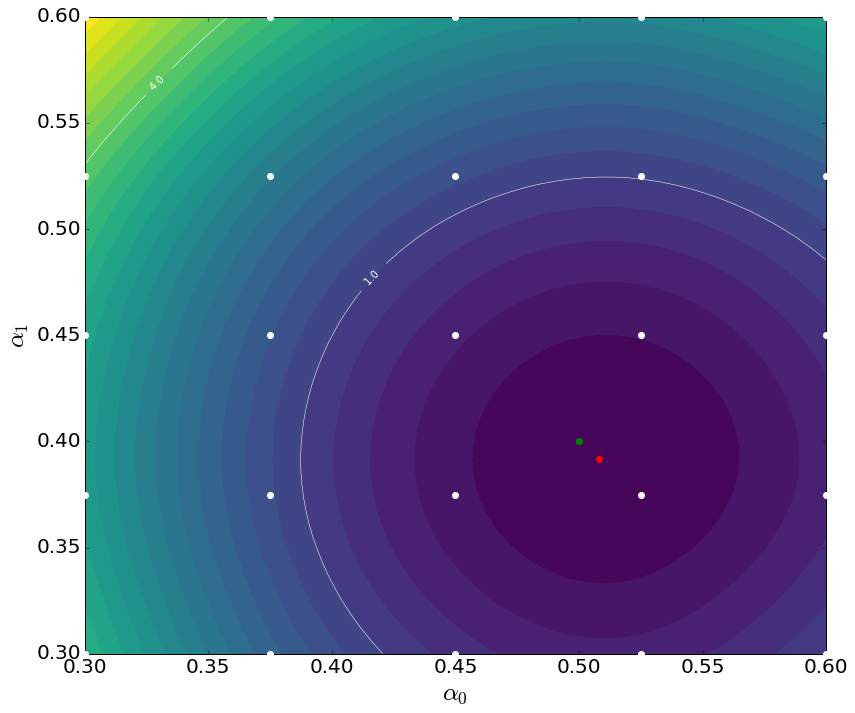

In [29]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
#plt.savefig('plots/alpha_gp_exact.pdf')
plt.show()

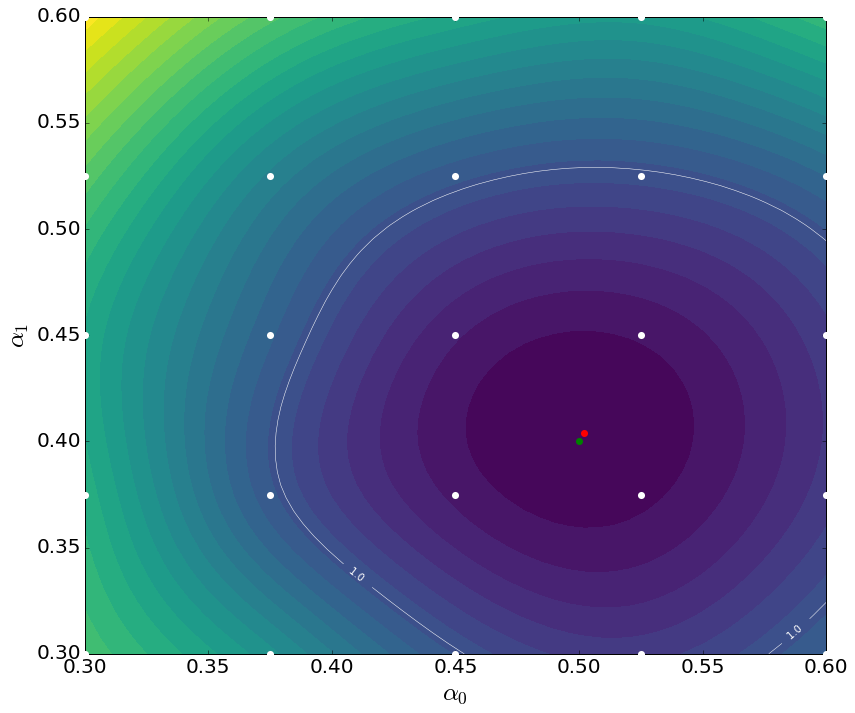

In [30]:
thetas = np.array([v for v in product(As, Bs)])

gp = GaussianProcessRegressor(alpha=0., normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 50)
yi = np.linspace(bounds[1][0], bounds[1][1], 50)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = plt.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
plt.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)

cs = plt.contourf(xi, yi, zi, 30,
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
plt.scatter(thetas[:,0],thetas[:,1], marker='o', c='w', s=50, lw=0, zorder=10)
plt.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([alpha_value_0],[alpha_value_1], marker='o', c='g', s=50, lw=0, zorder=10)

plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\alpha_0$", fontsize=25)
plt.ylabel(r"$\alpha_1$", fontsize=25)
plt.tight_layout()
#plt.savefig('plots/alpha_gp_approx.pdf')
plt.show()

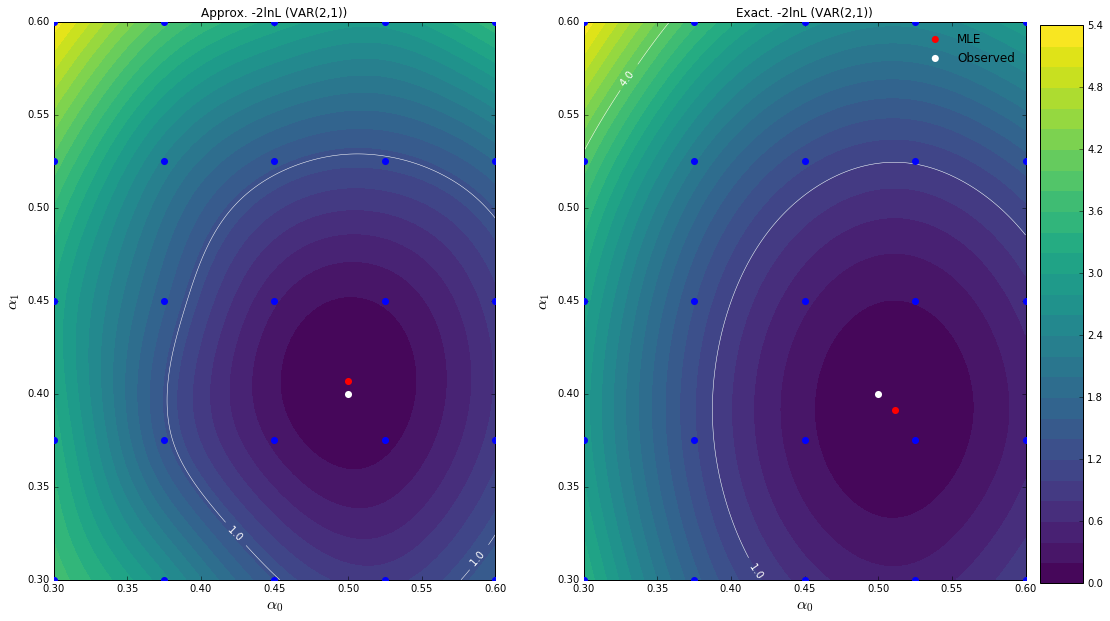

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = axes.flat[0]

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, llr)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs.levels = [nf(val) for val in cs.levels]
ax.clabel(cs, cs.levels, inline=1, fontsize=10, fmt = fmt)
cs = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

#plt.colorbar()
ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Approx. -2lnL (VAR(2,1))")

ax = axes.flat[1]

gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(thetas, exact_contours)

xi = np.linspace(bounds[0][0], bounds[0][1], 500)
yi = np.linspace(bounds[1][0], bounds[1][1], 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

mle = np.unravel_index(zi.argmin(),zi.shape)
zi -= zi[mle]
zi *= 2.

cs2 = ax.contour(xi, yi, zi, [1.,4.,9.,16.,25.], linewidths=0.5, colors='w')
cs2.levels = [nf(val) for val in cs2.levels]
ax.clabel(cs2, cs2.levels, inline=1, fontsize=10, fmt = fmt)
cs2 = ax.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.81, 0.12, 0.03, 0.775])
fig.colorbar(cs2, cax=cbar_ax)

ax.scatter(thetas[:,0],thetas[:,1], marker='o', c='b', s=50, lw=0, zorder=10)
smle = ax.scatter([xi[mle[1]]], [yi[mle[0]]], marker='o', c='r', s=50, lw=0, zorder=10)
sobs = ax.scatter([alpha_value_0],[alpha_value_1], marker='o', c='w', s=50, lw=0, zorder=10)

lines = [smle, sobs]
labels = ['MLE', 'Observed']

ax.legend(lines, labels, frameon=False, prop={'size':12}, scatterpoints=1)

ax.set_xlim(bounds[0][0], bounds[0][1])
ax.set_ylim(bounds[1][0], bounds[1][1])
ax.set_xlabel(r"$\alpha_0$", size=16)
ax.set_ylabel(r"$\alpha_1$", size=16)
ax.set_title("Exact. -2lnL (VAR(2,1))")

plt.show()
#plt.savefig('ar_2d_approx.pdf')

Plot grid of score distributions to check calibration

In [167]:
from carl.ratios.utils import plot_scores

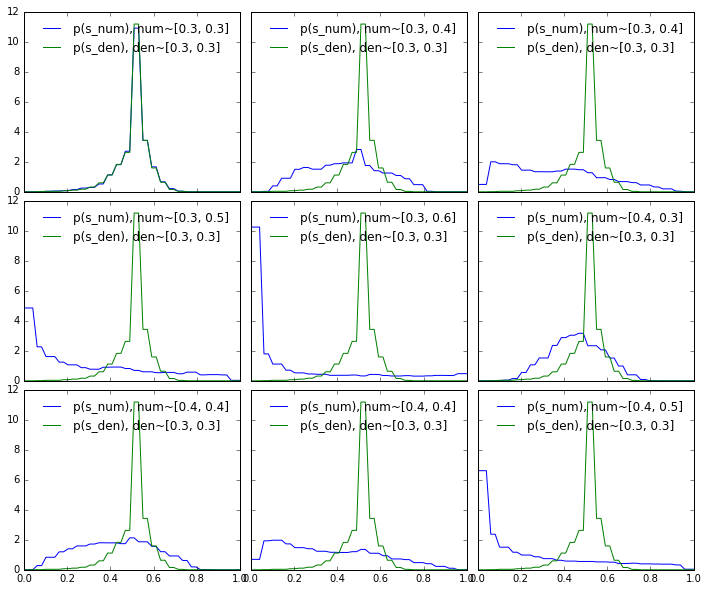

In [168]:
plot_scores(clf_ratios[0:9], 
            positions=[(l,bkg_position) for l in combinations[0:9]])